In [1]:
import torch
from torch import nn, optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import helper
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


print(len(trainloader))
print(len(testloader))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw

938
157


In [3]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

plt.tight_layout()


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper

In [4]:
class LeNet5(nn.Module):
    def __init__(self,do_dropout=False,do_batch_norm=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.batchnorm1 = nn.BatchNorm2d(6)
        self.relu = nn.ReLU()
        self.avgpool2d =  nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.batchnorm2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5,stride=1)
        self.batchnorm3 = nn.BatchNorm2d(120)

        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(in_features=120 , out_features=84)
        self.fc2 = nn.Linear(in_features=84 , out_features=10)
        self.dropout = nn.Dropout(p=0.15)
        self.do_dropout = do_dropout
        self.do_batch_norm = do_batch_norm


    def forward(self, x):
        x = self.conv1(x)
        if self.do_batch_norm:
          x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.avgpool2d(x) 
        x = self.conv2(x)
                
        if self.do_batch_norm:
          x = self.batchnorm2(x)

        x = self.avgpool2d(x)
        x = self.conv3(x)

        if self.do_batch_norm:
          x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.flatten(x) 
        x = self.fc1(x) 
        if self.do_dropout:
          x = self.dropout(x)
        x = self.relu(x)
        x = self.fc2(x)
        if self.do_dropout:
          x = self.dropout(x)
        return x

In [5]:
batch_norm = False
dropout = False
weight_decay = False

if batch_norm:
    save_name = 'batch_norm.p'
elif dropout:
    save_name = 'mymodel_dropout.p'
elif weight_decay:
    save_name ='mymodel_weight_decay.p'
else:
  save_name ='no_reg.p'


model = LeNet5(dropout, batch_norm)
criterion = nn.CrossEntropyLoss(reduction = 'sum')
if weight_decay:
   optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4)
else:
   optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
train_losses, test_losses = [], []
train_acc, test_acc = [], []
for e in range(epochs):
  tot_train_loss = 0
  train_correct = 0
  for images, labels in (trainloader):

    log_ps = model(images)
    loss = criterion(log_ps, labels)
    tot_train_loss += loss.item()
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()
    top_p, top_class = log_ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    train_correct += equals.sum().item()

  else:
        tot_test_loss = 0
        test_correct = 0  # Number of correct predictions on the test set

        with torch.no_grad():
          model.eval()
          for images, labels in (testloader):
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            tot_test_loss += loss.item()

            top_p, top_class = log_ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_correct += equals.sum().item()

        model.train()

        train_loss = tot_train_loss / len(trainloader.dataset)
        test_loss = tot_test_loss / len(testloader.dataset)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_acc.append(train_correct / len(trainloader.dataset))
        test_acc.append(test_correct / len(testloader.dataset))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(test_loss),
              "Training Accuracy: {:.4f}..".format(train_correct / len(trainloader.dataset)),
              "Test Accuracy: {:.4f}..".format(test_correct / len(testloader.dataset)))


torch.save(model.state_dict(), save_name)


Epoch: 1/20..  Training Loss: 0.617..  Test Loss: 0.477..  Training Accuracy: 0.7692.. Test Accuracy: 0.8271..
Epoch: 2/20..  Training Loss: 0.403..  Test Loss: 0.412..  Training Accuracy: 0.8502.. Test Accuracy: 0.8512..
Epoch: 3/20..  Training Loss: 0.346..  Test Loss: 0.362..  Training Accuracy: 0.8732.. Test Accuracy: 0.8664..
Epoch: 4/20..  Training Loss: 0.315..  Test Loss: 0.346..  Training Accuracy: 0.8830.. Test Accuracy: 0.8717..
Epoch: 5/20..  Training Loss: 0.292..  Test Loss: 0.324..  Training Accuracy: 0.8910.. Test Accuracy: 0.8826..
Epoch: 6/20..  Training Loss: 0.273..  Test Loss: 0.310..  Training Accuracy: 0.8986.. Test Accuracy: 0.8875..
Epoch: 7/20..  Training Loss: 0.258..  Test Loss: 0.315..  Training Accuracy: 0.9040.. Test Accuracy: 0.8831..
Epoch: 8/20..  Training Loss: 0.245..  Test Loss: 0.284..  Training Accuracy: 0.9086.. Test Accuracy: 0.8955..
Epoch: 9/20..  Training Loss: 0.232..  Test Loss: 0.287..  Training Accuracy: 0.9135.. Test Accuracy: 0.8956..
E

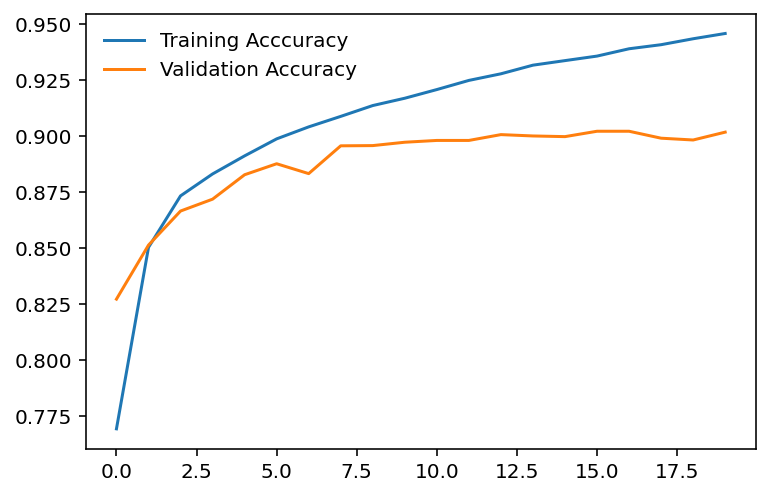

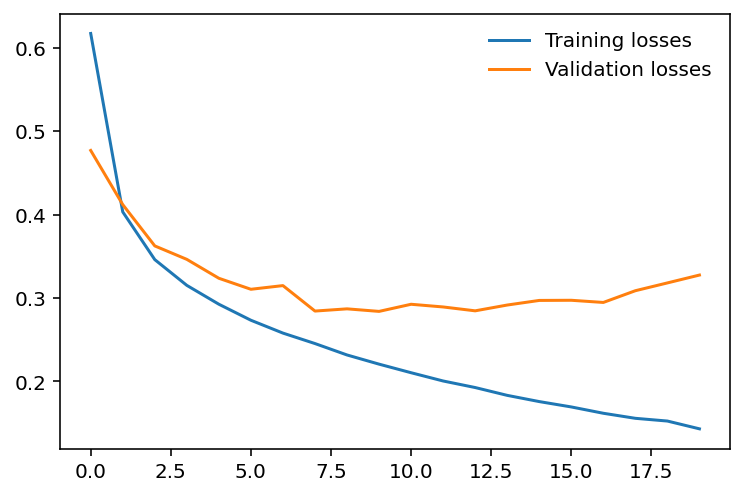

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt


plt.plot(train_acc, label='Training Acccuracy')
plt.plot(test_acc, label='Validation Accuracy')
plt.legend(frameon=False)
plt.show()

plt.plot(train_losses, label='Training losses')
plt.plot(test_losses, label='Validation losses')
plt.legend(frameon=False)
plt.show()



In [7]:
state_dict = torch.load(save_name)
#print(state_dict.keys())

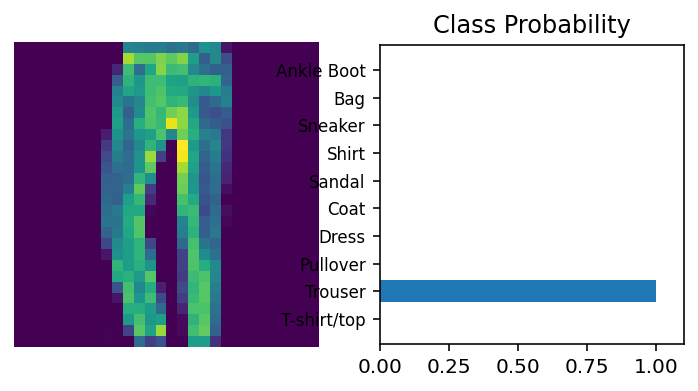

In [31]:
## Inference

batch_norm = False
dropout = False
weight_decay = False

if batch_norm:
    save_name = 'batch_norm.p'
elif dropout:
    save_name = 'mymodel_dropout.p'
elif weight_decay:
    save_name ='mymodel_weight_decay.p'
else:
  save_name ='no_reg.p'

model.load_state_dict(torch.load(save_name))

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[:1]

with torch.no_grad():
    output = model.forward(img)

ps = F.softmax(output, dim=1)

view_classify(img, ps, version='Fashion')